In [ ]:
path = 'patches500'
batch_size = 16
class_names = {'non-tumor': 0,
               'adenocarcinoma': 1,
               'hematopoietic ': 2,
               'squamous cell carcinoma ': 3,
               'melanoma': 4,
               'neuroendocrine carcinoma ': 5,
               'sarcoma ': 6,
               'urothelial carcinoma ': 7,}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import Counter
import sys
from sklearn.model_selection import train_test_split
import cv2, os
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.models import resnet18, mobilenet_v2
from torcheval.metrics import MulticlassAccuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch import nn
from torch.nn import functional as F
import torch.nn.init as init

In [3]:
def list_flatten(lis):
    flatList = []
    for element in lis:
        if type(element) is list:
            for item in element:
                flatList.append(item)
        else:
            flatList.append(element)
    return flatList

In [4]:
train_df = pd.read_json('train_df.json')
valid_df = pd.read_json('valid_df.json')

In [5]:
train_df['label'] = train_df['patches'].apply(lambda x: x.split('_')[-1])
valid_df['label'] = valid_df['patches'].apply(lambda x: x.split('_')[-1])

In [6]:
def patch_split(df):
    patches = []
    for i in range(len(df)):
        count_patches = df['count_patches'][i]
        count_patches = count_patches%batch_size
        temp = df['path'][i]
        if count_patches!=0:
            count_patches = batch_size - count_patches
            temp = temp + temp[-count_patches:]
        for j in range(0,len(temp),16):
            patches.append(temp[j:j+16])
    return patches

train_patches , valid_patches = [] , []

train_patches = patch_split(train_df)
valid_patches = patch_split(valid_df)

In [7]:
'''
df = pd.DataFrame(train_patients, columns=['files'])
df['label'] = df['files'].apply(lambda x: int(x.split('_')[4]))

counter = Counter(df['label'])
max_val = float(max(counter.values()))

counter = Counter(df['label'])
max_val = float(max(counter.values()))
class_weights = [max_val/num_images for _, num_images in counter.items()]

class_weights = torch.FloatTensor(class_weights).to('cuda')
'''

"\ndf = pd.DataFrame(train_patients, columns=['files'])\ndf['label'] = df['files'].apply(lambda x: int(x.split('_')[4]))\n\ncounter = Counter(df['label'])\nmax_val = float(max(counter.values()))\n\ncounter = Counter(df['label'])\nmax_val = float(max(counter.values()))\nclass_weights = [max_val/num_images for _, num_images in counter.items()]\n\nclass_weights = torch.FloatTensor(class_weights).to('cuda')\n"

In [8]:
class_changer = {0:0, 
                1:1, 2:1, 3:1, 4:1, 5:1}

In [9]:
class DATASET(torch.utils.data.Dataset):
    def __init__(self, data, batch_size, class_name):
        self.data = data
        self.batch_size = batch_size
        self.class_name = class_name
    
    def __getitem__(self, i):
        image = np.zeros((self.batch_size,3,224,224), dtype='float32')
        for j in range(self.batch_size):
            temp = cv2.cvtColor(cv2.imread(self.data[i][j]), cv2.COLOR_BGR2RGB)/255
            image[j] = temp.transpose(2, 0, 1)

        label = int(self.data[i][0].split('_')[4])
        label = self.class_name[label]
        target = np.zeros((2))
        target[label] = 1
        target = target.astype('float32')
        return image, target

    def __len__(self):
        return len(self.data)
    
train_dataset= DATASET(train_patches, batch_size, class_changer)
valid_dataset = DATASET(valid_patches, batch_size, class_changer)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=6)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=6)

In [10]:
class Attn_Net(nn.Module):

    def __init__(self, L = 1280, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net, self).__init__()
        self.module = [
            nn.Linear(L, D),
            nn.Tanh()]

        if dropout:
            self.module.append(nn.Dropout(0.25))

        self.module.append(nn.Linear(D, n_classes))
        
        self.module = nn.Sequential(*self.module)
    
    def forward(self, x):
        return self.module(x), x # N x n_classes

"""
Attention Network with Sigmoid Gating (3 fc layers)
args:
    L: input feature dimension
    D: hidden layer dimension
    dropout: whether to use dropout (p = 0.25)
    n_classes: number of classes 
"""
class Attn_Net_Gated(nn.Module):
    def __init__(self, L = 1280, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net_Gated, self).__init__()
        self.attention_a = [
            nn.Linear(L, D),
            nn.Tanh()]
        
        self.attention_b = [nn.Linear(L, D),
                            nn.Sigmoid()]
        if dropout:
            self.attention_a.append(nn.Dropout(0.25))
            self.attention_b.append(nn.Dropout(0.25))

        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        
        self.attention_c = nn.Linear(D, n_classes)

    def forward(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = a.mul(b)
        A = self.attention_c(A)  # N x n_classes
        return A, x

"""
args:
    gate: whether to use gated attention network
    size_arg: config for network size
    dropout: whether to use dropout
    k_sample: number of positive/neg patches to sample for instance-level training
    dropout: whether to use dropout (p = 0.25)
    n_classes: number of classes 
    instance_loss_fn: loss function to supervise instance-level training
    subtyping: whether it's a subtyping problem
"""
class CLAM_SB(nn.Module):
    def __init__(self, gate = True, size_arg = "small", dropout = False, k_sample=16, n_classes=2,
        instance_loss_fn=nn.CrossEntropyLoss(), subtyping=False):
        super(CLAM_SB, self).__init__()

        resnet = mobilenet_v2(weights=None)
        # for p in resnet.parameters():
        #     p.requires_grad = False
        self.features = nn.Sequential(*list(resnet.children())[:-1], nn.AvgPool2d(7,7), nn.Flatten())

        self.size_dict = {"small": [1280, 512, 256], "big": [1280, 512, 384]}
        size = self.size_dict[size_arg]
        fc = [nn.Linear(size[0], size[1]), nn.ReLU()]
        if dropout:
            fc.append(nn.Dropout(0.25))
        if gate:
            attention_net = Attn_Net_Gated(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        else:
            attention_net = Attn_Net(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        fc.append(attention_net)
        self.attention_net = nn.Sequential(*fc)
        self.classifiers = nn.Linear(size[1], n_classes)
        instance_classifiers = [nn.Linear(size[1], 2) for i in range(n_classes)]
        self.instance_classifiers = nn.ModuleList(instance_classifiers)
        self.k_sample = k_sample
        self.instance_loss_fn = instance_loss_fn
        self.n_classes = n_classes
        self.subtyping = subtyping

        # initialize_weights(self)

    def relocate(self):
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.attention_net = self.attention_net.to(device)
        self.classifiers = self.classifiers.to(device)
        self.instance_classifiers = self.instance_classifiers.to(device)
    
    @staticmethod
    def create_positive_targets(length, device):
        return torch.full((length, ), 1, device=device).long()
    @staticmethod
    def create_negative_targets(length, device):
        return torch.full((length, ), 0, device=device).long()
    
    #instance-level evaluation for in-the-class attention branch
    def inst_eval(self, A, h, classifier): 
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        top_n_ids = torch.topk(-A, self.k_sample, dim=1)[1][-1]
        top_n = torch.index_select(h, dim=0, index=top_n_ids)
        p_targets = self.create_positive_targets(self.k_sample, device)
        n_targets = self.create_negative_targets(self.k_sample, device)

        all_targets = torch.cat([p_targets, n_targets], dim=0)
        all_instances = torch.cat([top_p, top_n], dim=0)
        logits = classifier(all_instances)
        all_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, all_targets)
        return instance_loss, all_preds, all_targets
    
    #instance-level evaluation for out-of-the-class attention branch
    def inst_eval_out(self, A, h, classifier):
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        p_targets = self.create_negative_targets(self.k_sample, device)
        logits = classifier(top_p)
        p_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, p_targets)
        return instance_loss, p_preds, p_targets

    def forward(self, h, label=None, instance_eval=False, return_features=False, attention_only=False):
        device = h.device
        h = self.features(h)
        A, h = self.attention_net(h)  # NxK        
        A = torch.transpose(A, 1, 0)  # KxN
        if attention_only:
            return A
        A_raw = A
        A = F.softmax(A, dim=1)  # softmax over N

        if instance_eval:
            total_inst_loss = 0.0
            all_preds = []
            all_targets = []
            inst_labels = F.one_hot(label, num_classes=self.n_classes).squeeze() #binarize label
            for i in range(len(self.instance_classifiers)):
                inst_label = inst_labels[i].item()
                classifier = self.instance_classifiers[i]
                if inst_label == 1: #in-the-class:
                    instance_loss, preds, targets = self.inst_eval(A, h, classifier)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                else: #out-of-the-class
                    if self.subtyping:
                        instance_loss, preds, targets = self.inst_eval_out(A, h, classifier)
                        all_preds.extend(preds.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())
                    else:
                        continue
                total_inst_loss += instance_loss

            if self.subtyping:
                total_inst_loss /= len(self.instance_classifiers)
                
        M = torch.mm(A, h) 
        logits = self.classifiers(M)
        Y_hat = torch.topk(logits, 1, dim = 1)[1]
        Y_prob = F.softmax(logits, dim = 1)
        if instance_eval:
            results_dict = {'instance_loss': total_inst_loss, 'inst_labels': np.array(all_targets), 
            'inst_preds': np.array(all_preds)}
        else:
            results_dict = {}
        if return_features:
            results_dict.update({'features': M})
        return logits, Y_prob, Y_hat, A_raw, results_dict
        # return Y_prob

model = CLAM_SB(n_classes=2, dropout=0.5, k_sample=batch_size)

In [13]:

model = model.to('cuda')
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001),])
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1, verbose=True)

epochs = 10
counter = 1
best_valid_loss = np.inf
len_train_loader = len(train_loader)
len_valid_loader = len(valid_loader)
metric = MulticlassAccuracy(num_classes=2).to('cuda')
history = [['train_loss', 'train_acc', 'valid_loss', 'valid_acc']]
for i in range(1, epochs + 1):
    running_loss = 0
    model.train()
    y_true, y_pred = [] , []
    for batch_ind, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        targets = targets.to('cuda')
        predicted = model(images[0].to('cuda'))
        loss = criterion(predicted[0], targets)

        loss.backward()
        optimizer.step()

        running_loss += loss

        train_acc = float(metric.update(predicted[1].argmax(dim=1), targets.argmax(dim=1)).compute())
        sys.stdout.write("\rTrain Loss: {:<4.4f}, Acc {:<6.4f}, Progress: {:4.2f}". format(running_loss/(batch_ind+1), train_acc*100, ((batch_ind+1)/len_train_loader)*100))
        sys.stdout.flush()
    train_loss = running_loss/len_train_loader
    
    y_true, y_pred = [] , []
    # metric.reset()
    with torch.no_grad():
        running_loss = 0
        model.eval()
        for batch_ind, (images, targets) in enumerate(valid_loader):
            predicted = model(images[0].to('cuda'))
            targets = targets.to('cuda')
            loss = criterion(predicted[0], targets)
            running_loss += loss
            valid_acc = float(metric.update(predicted[1].argmax(dim=1), targets.argmax(dim=1)).compute())
            sys.stdout.write("\rTrain Loss: {:4.4f}, Acc {:<6.4f}, Valid Loss: {:4.4f}, Acc {:<6.4f}, Progress: {:4.2f}". format(train_loss, train_acc*100, running_loss/(batch_ind+1), valid_acc*100, ((batch_ind+1)/len_valid_loader)*100))
            sys.stdout.flush()

        valid_loss = running_loss/len_valid_loader
    # metric.reset()
    sys.stdout.flush()
    sys.stdout.write("\r"+" "*200)
    sys.stdout.write("\rTrain Loss: {:4.4f}, Acc {:<6.4f}, Valid Loss: {:4.4f}, Acc {:<6.4f}".format(train_loss, train_acc*100, valid_loss, valid_acc*100))
    sys.stdout.write("\r\n")
    sys.stdout.flush()

    history.append([float(train_loss), train_acc, float(valid_loss), valid_acc])
    if valid_loss<best_valid_loss:
        torch.save(model.state_dict(), 'weights.pth')
        print('Model saved.')
        best_valid_loss = valid_loss
        counter=1
    elif valid_loss>best_valid_loss:
        counter+=1

    if counter==3:
        model.load_state_dict(torch.load('weights.pth'))
        counter=1

    scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.2421, Acc 97.4392, Valid Loss: 0.1667, Acc 96.0317                                                                                                                                        
Model saved.
Adjusting learning rate of group 0 to 1.0000e-04.
Train Loss: 0.1130, Acc 97.4392, Valid Loss: 0.1457, Acc 96.0317                                                                                                                                        
Model saved.
Adjusting learning rate of group 0 to 1.0000e-05.
Train Loss: 0.1043, Acc 97.4392, Valid Loss: 0.1569, Acc 96.0317                                                                                                                                        
Adjusting learning rate of group 0 to 1.0000e-06.
Train Loss: 0.0988, Acc 97.4392, Valid Loss: 0.1438, Acc 96.0317                                                                                                           

KeyboardInterrupt: 

In [14]:
history_df = pd.DataFrame(history[1:], columns=history[0])

# plot metrics

In [15]:
def plot_history(df, metric):
    plt.plot(df['train_'+metric])
    plt.plot(df['valid_'+metric])

    plt.title('model {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('results/{}.png'.format(metric))
    plt.close()

for metrics in ['loss', 'acc']:
    plot_history(history_df, metrics)

# confusion matrix

In [32]:
class DATASET(torch.utils.data.Dataset):
    def __init__(self, data, batch_size, class_name):
        self.data = data
        self.batch_size = batch_size
        self.class_name = class_name
    
    def __getitem__(self, i):
        image = np.zeros((self.batch_size,3,224,224), dtype='float32')
        for j in range(self.batch_size):
            temp = cv2.cvtColor(cv2.imread(self.data[i][j]), cv2.COLOR_BGR2RGB)/255
            image[j] = temp.transpose(2, 0, 1)

        label = int(self.data[i][0].split('_')[4])
        label = self.class_name[label]
        target = np.zeros((2))
        target[label] = 1
        target = target.astype('float32')
        return image, target, self.data[i][0]

    def __len__(self):
        return len(self.data)
valid_dataset = DATASET(valid_patches, batch_size, class_changer)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=6)

patches500/10_img1_11_label_0_patch_00_.png
patches500/10_img1_16_label_0_patch_00_.png
patches500/10_img1_21_label_0_patch_00_.png
patches500/10_img1_6_label_0_patch_00_.png
patches500/10_img2_11_label_0_patch_00_.png
patches500/10_img2_16_label_0_patch_00_.png
patches500/10_img2_21_label_0_patch_00_.png
patches500/10_img2_6_label_0_patch_00_.png
patches500/10_img8_11_label_0_patch_00_.png
patches500/10_img8_16_label_0_patch_00_.png
patches500/10_img8_21_label_0_patch_00_.png
patches500/10_img8_6_label_0_patch_00_.png
patches500/10_img9_11_label_0_patch_00_.png
patches500/10_img9_16_label_0_patch_00_.png
patches500/10_img9_21_label_0_patch_00_.png
patches500/10_img9_6_label_0_patch_00_.png
patches500/11_img3_11_label_0_patch_00_.png
patches500/11_img3_16_label_0_patch_00_.png
patches500/11_img3_21_label_0_patch_00_.png
patches500/11_img3_6_label_0_patch_00_.png


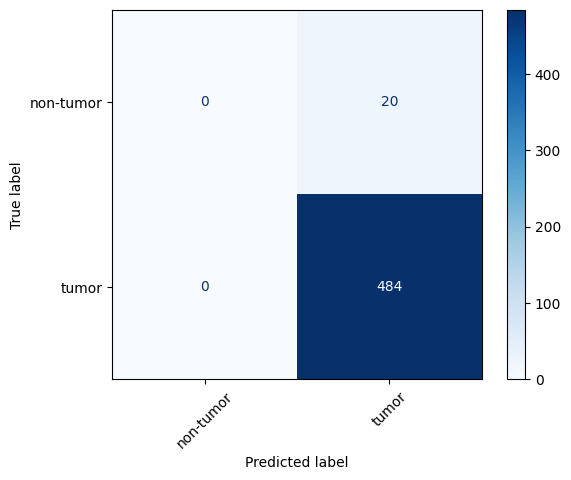

In [41]:
model.load_state_dict(torch.load('weights.pth'))

metric = MulticlassAccuracy(num_classes=2).to('cuda')
y_true, y_pred = [] , []
with torch.no_grad():
    model.eval()
    for batch_ind, (images, targets, name) in enumerate(valid_loader):
        predicted = model(images[0].to('cuda'))
        targets = targets.to('cuda')
        loss = criterion(predicted[0], targets)
        running_loss += loss

        valid_acc = float(metric.update(predicted[1].argmax(dim=1), targets.argmax(dim=1)).compute())

        temp_pred = predicted[1].argmax(dim=1)
        temp_true = targets.argmax(dim=1)

        y_true.append(int(temp_true))
        y_pred.append(int(temp_pred))

        if temp_pred!=temp_true:
            print(name[0])
        # sys.stdout.write("\rValid Loss: {:4.4f}, Acc {:<6.4f}, Progress: {:4.2f}". format(running_loss/(batch_ind+1), valid_acc*100, ((batch_ind+1)/len_valid_loader)*100))
        # sys.stdout.flush()


disp= ConfusionMatrixDisplay.from_predictions(y_true= y_true,
                                              y_pred= y_pred,
                                              xticks_rotation= 45,
                                              cmap='Blues', 
                                              display_labels=['non-tumor','tumor'],)

disp.figure_.savefig('results/{}.png'.format('confusion_matrix'), bbox_inches = 'tight')
